In [1]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# DRAW MATPLOTLIB IN NOTEBOOK #

#%matplotlib inline
#%matplotlib notebook



# LIBRARIES #

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage

import SimpleITK

In [4]:
# INPUT PARAMETERS #
#m_filename = 'G:/Commun/PHYSICIENS/cyber M6/OF/EBT3/colli5_200dpi.tif'
m_filename = 'colli5_72dpi.tif'

m_coefA = 1774.1   #x3
m_coefB = -3907.8  #x2
m_coefC = 3276.7   #x
m_coefD = -935.12

max of top graph    96.399
max of right graph  96.501


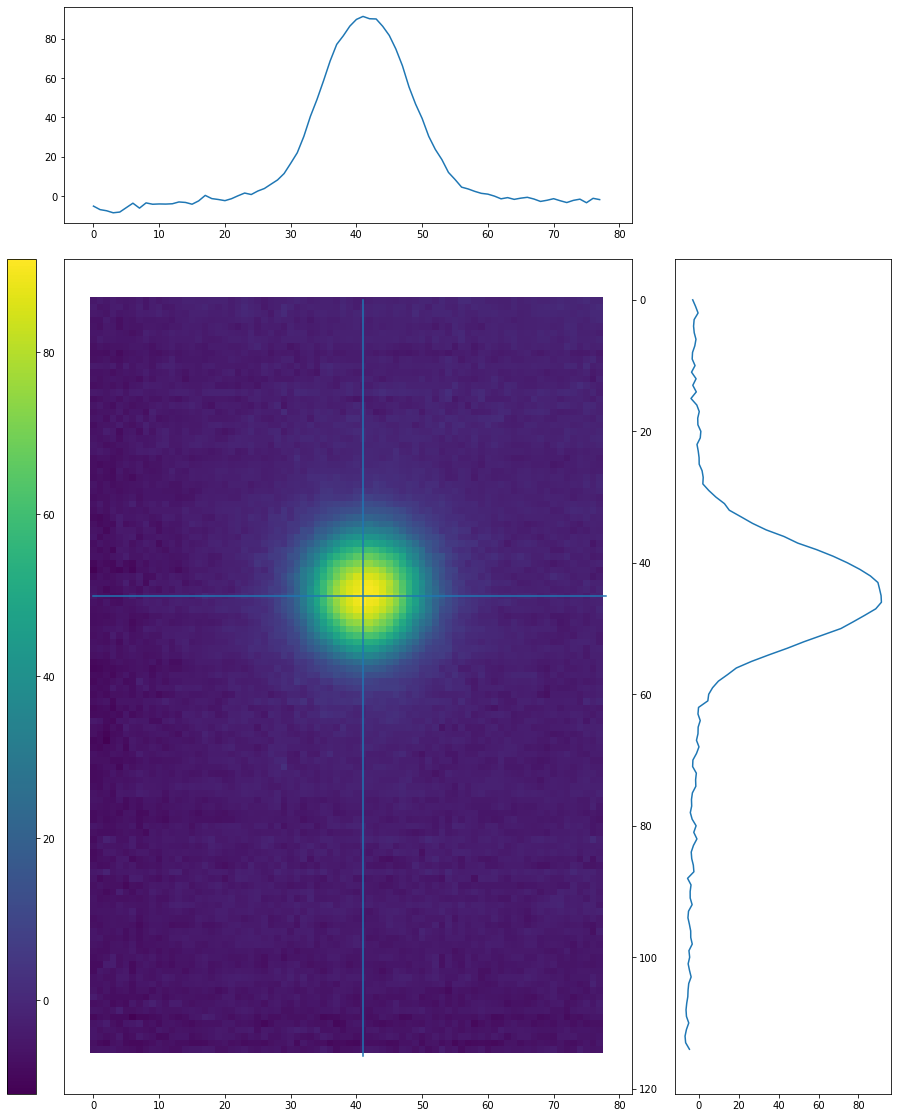

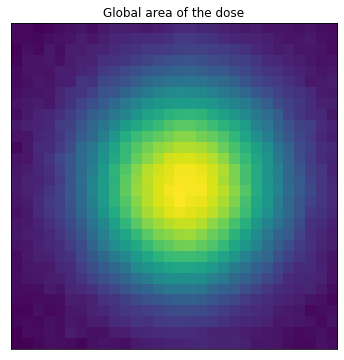

In [5]:
# READS THE IMAGE AND CONVERTS IT TO DOSE #

def readAndConvertImg(filename, coefs):
    # reads the image using simpleITK:
    img = SimpleITK.ReadImage(filename)
    sizex = img.GetWidth()
    sizey = img.GetHeight()
    array = SimpleITK.GetArrayFromImage(img)

    # replaces every 65535 value in array with 65534 to avoid division by zero:
    array[array==65535]=65534

    # converts in optical density
    dor = -np.log10(array[:,:,0]/65535.0)
    dob = -np.log10(array[:,:,2]/65535.0)

    # red channel over blue channel:
    rsb = dor/dob
    rsb[rsb>1.3] = 1.3

    # converting in dose:
    dose = coefs[0]*rsb**3 + coefs[1]*rsb**2 + coefs[2]*rsb + coefs[3]

    return dose, sizex, sizey



# PLOTS THE DOSE IMAGE #

coefs = [m_coefA, m_coefB, m_coefC, m_coefD]

doseimg, sizex, sizey = readAndConvertImg(m_filename, coefs)

# initiates the size of the figure
plt.rcParams['figure.figsize'] = (30,20)

fig, ax1 = plt.subplots()
im1 = ax1.imshow(doseimg)#, cmap="Greys", vmin = 0, vmax = 100)
ax1.yaxis.set_label_position('right')
ax1.yaxis.tick_right()
#ax1.set_title('Dose')

# locates the most irradiation
com = ndimage.measurements.center_of_mass(doseimg[10:sizex-10,10:sizey-10])
comx = int(com[1])+10
comy = int(com[0])+10

# pinpoints the center of the zone
com = ndimage.measurements.center_of_mass(doseimg[comy-10:comy+10, comx-10:comx+10])
comx += int(com[1])-10
comy += int(com[0])-10

#comx = 45
#comy = 41

# displays the surrounding area of the point (comx, comy)
fig2, axn = plt.subplots(figsize=(6, 6))
imn = axn.imshow(doseimg[comy-15:comy+15, comx-15:comx+15])
axn.set_title('Global area of the dose')
axn.get_xaxis().set_visible(False)
axn.get_yaxis().set_visible(False)


# Points 
linex = [0,sizex]
liney = [comy,comy]
line1 = plt.Line2D(linex, liney)
ax1.add_line(line1)
linex = [comx,comx]
liney = [0,sizey]
line2 = plt.Line2D(linex, liney)
ax1.add_line(line2)


try:
    divider1 = make_axes_locatable(ax1)
    
    # color bar creation
    cax1 = divider1.append_axes('left', size='5%', pad=0.4)
    plt.colorbar(im1, cax=cax1)
    
    # top graph creation
    ax2 = divider1.append_axes('top', 3, pad=0.5, sharex=ax1)
    ax2.plot(doseimg[comy,:])
    
    # right graph creation
    ax3 = divider1.append_axes('right', 3, pad=0.6, sharey=ax1)
    ax3.plot(doseimg[:,comx],range(sizey))
    ax3.yaxis.set_visible(False)
    
    print("max of top graph", "{:9.3f}".format(ax2.get_ylim()[1]))
    print("max of right graph", "{:7.3f}".format(ax3.get_xlim()[1]))
    
except:
    print('Error displaying graphs and side bars')